In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:37315")
client

<Client: 'tcp://127.0.0.1:37315' processes=8 threads=32, memory=125.85 GiB>

In [2]:
client.restart()

<Client: 'tcp://127.0.0.1:37315' processes=0 threads=0, memory=0 B>

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from xgcm.grid import Grid
from xhistogram.xarray import histogram as xhist
from scipy.interpolate import griddata
import gcm_filters
import gsw
import xrft
import s3fs
import os.path as op
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
sdir = '/tank/spectre/tuchida/MLI/'

In [5]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

In [6]:
reg = 1
dss = cat.eNATL60(region=str(reg),datatype='surface_hourly', season='fma'
                 ).to_dask()
dss.coords['day'] = ('time_counter',np.repeat(np.arange(len(dss.time_counter)//24),
                                              24))
dss = dss.groupby('day').mean('time_counter',skipna=True)

dss

<xarray.Dataset>
Dimensions:   (y: 763, x: 611, day: 89)
Coordinates: (12/14)
    depth     (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1f       (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1t       (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1u       (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1v       (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e2f       (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    ...        ...
    e2v       (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    lat       (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    lon       (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lat   (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lon   (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
  * day       (day) int64 0 1 2 3 4 5 6 7 8 9 ... 79 80 81 82 83 84 85 86 87 88
Dimensions without coordinates: y, x
Data variables: (12/13)
    fmask     (day, y, x) int8 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    qt_oce    (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    somecrty  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sometauy  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sosaline  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sossheig  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    ...        ...
    sowaflup  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sozocrtx  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sozotaux  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    tmask     (day, y, x) int8 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    umask     (day, y, x) int8 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    vmask     (day, y, x) int8 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>

In [7]:
dsi = cat.eNATL60(region=str(reg),datatype='interior_daily', season='fma'
                 ).to_dask().isel(deptht=slice(None,-1),depthv=slice(None,-1),
                                  depthu=slice(None,-1)
                                 ).chunk({'deptht':5,'depthw':5,
                                          'depthv':5,'depthu':5}
                                        )
dsi

<xarray.Dataset>
Dimensions:       (y: 763, x: 611, deptht: 106, depthu: 106, depthv: 106,
                   depthw: 107, time_counter: 89)
Coordinates: (12/18)
    depth         (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
  * deptht        (deptht) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthu        (depthu) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthv        (depthv) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthw        (depthw) float32 0.0 1.0 2.157 3.471 ... 960.0 976.9 993.8
    e1f           (y, x) float64 dask.array<chunksize=(73, 611), meta=np.ndarray>
    ...            ...
    e2v           (y, x) float64 dask.array<chunksize=(73, 611), meta=np.ndarray>
    lat           (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
    lon           (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2010-02-01 ... 2010-04-30
Dimensions without coordinates: y, x
Data variables: (12/13)
    e3t_0         (deptht, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    e3u_0         (depthu, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    e3v_0         (depthv, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    e3w_0         (depthw, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    fmask         (deptht, y, x) int8 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    tmask         (deptht, y, x) int8 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    ...            ...
    vmask         (depthv, y, x) int8 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    vomecrty      (time_counter, depthv, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    vosaline      (time_counter, deptht, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    votemper      (time_counter, deptht, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    vovecrtz      (time_counter, depthw, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    vozocrtx      (time_counter, depthu, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>

In [8]:
YC = dss.lat.mean('x')
XC = dss.lon.mean('y')
YG = xr.concat([YC[0]-YC.diff('y').min(skipna=True),
                .5*(YC[1:] + YC[:-1])
               ],'y')
XG = xr.concat([XC[0]-XC.diff('x').min(skipna=True),
                .5*(XC[1:] + XC[:-1])
               ],'x')

In [9]:
taux = xr.DataArray(dss.sozotaux.data, dims=['time','YC','XG'],
                    coords={'YC':YC.data,'XG':XG.data}
                   )
tauy = xr.DataArray(dss.sometauy.data, dims=['time','YG','XC'],
                    coords={'YG':YG.data,'XC':XC.data}
                   )
fwf  = xr.DataArray(dss.sowaflup.data, dims=['time','YC','XC'],
                    coords={'YC':YC.data,'XC':XC.data}
                   )
Q    = xr.DataArray(dss.qt_oce.data, dims=['time','YC','XC'],
                    coords={'YC':YC.data,'XC':XC.data}
                   )

In [10]:
v  = xr.DataArray(dsi.vomecrty.data, dims=['time','Z','YG','XC'],
                  coords={'Z':dsi.depthv.data,'YG':YG.data,'XC':XC.data}
                 )
u  = xr.DataArray(dsi.vozocrtx, dims=['time','Z','YC','XG'],
                  coords={'Z':dsi.depthu.data,'YC':YC.data,'XG':XG.data}
                 )
w  = xr.DataArray(dsi.vovecrtz.data, dims=['time','Zp1','YC','XC'],
                  coords={'Zp1':dsi.depthw.data,'YC':YC.data,'XC':XC.data}
                 )
CT = xr.DataArray(dsi.votemper.data, dims=['time','Z','YC','XC'],
                  coords={'Z':dsi.deptht.data,'YC':YC.data,'XC':XC.data}
                 )
SA = xr.DataArray(dsi.vosaline, dims=['time','Z','YC','XC'],
                  coords={'Z':dsi.deptht.data,'YC':YC.data,'XC':XC.data}
                 )

In [11]:
ds = CT.to_dataset(name='CT')
ds['SA'] = SA
ds['U'] = u
ds['V'] = v
ds['W'] = w
ds['taux'] = taux  # N/m2 = (kg.m/s2)/m2
ds['tauy'] = tauy  # N/m2
ds['Ffw'] = fwf    # kg/m2/s
ds['Q'] = Q        # W/m2 = (N.m/s)/m2 = (kg.m2/s3)/m2
ds.coords['lat'] = xr.DataArray(dsi.lat.data, dims=['YC','XC'],
                           coords={'YC':YC.data,'XC':XC.data}
                          )
ds.coords['lon'] = xr.DataArray(dsi.lon.data, dims=['YC','XC'],
                           coords={'YC':YC.data,'XC':XC.data}
                          )
ds.coords['maskC'] = xr.DataArray(dsi.tmask.data, dims=['Z','YC','XC'],
                           coords={'Z':dsi.deptht.data,
                                   'YC':YC.data,'XC':XC.data}
                          )
ds.coords['maskW'] = xr.DataArray(dsi.umask.data, dims=['Z','YC','XG'],
                           coords={'Z':dsi.deptht.data,
                                   'YC':YC.data,'XG':XG.data}
                          )
ds.coords['maskS'] = xr.DataArray(dsi.vmask.data, dims=['Z','YG','XC'],
                           coords={'Z':dsi.deptht.data,
                                   'YG':YG.data,'XC':XC.data}
                          )
ds.coords['maskG'] = xr.DataArray(dsi.fmask.data, dims=['Z','YG','XG'],
                           coords={'Z':dsi.deptht.data,
                                   'YG':YG.data,'XG':XG.data}
                          )
ds = ds.chunk({'time':1,'YC':100,'XC':100})

coords={
        "X": {"center": "XC", "left": "XG"},
        "Y": {"center": "YC", "left": "YG"},
        "Z": {"center": "Z",  "outer":"Zp1"}
       }
grid = Grid(ds, periodic=[],
            coords=coords
           )
grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
Z Axis (not periodic, boundary=None):
  * center   Z --> outer
  * outer    Zp1 --> center

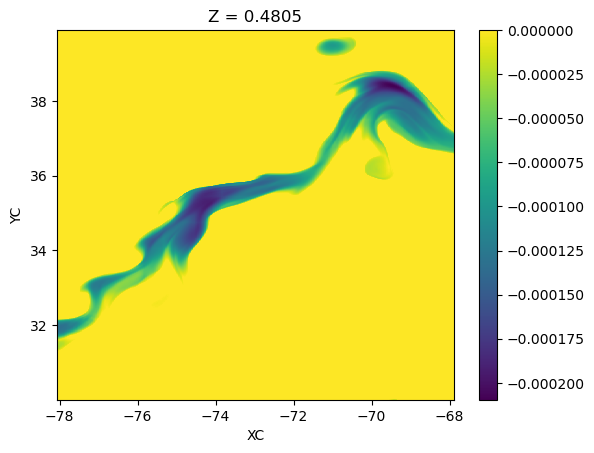

In [12]:
alpha = xr.apply_ufunc(gsw.alpha,  # 1/K
                       SA.isel(Z=0), CT.isel(Z=0), 0., 
                       dask='parallelized'
                      ) 
Cp = 1005.
rho_air = 1.225
grav = 9.81
B0 = grav*alpha * (ds.Q/rho_air/Cp)
B0 = B0.where(B0<0.).fillna(0.)
B0.isel(time=62).plot()

In [13]:
rho0 = 1000.
ustar = np.sqrt(np.sqrt(grid.interp(ds.taux**2,'X',boundary='extend') 
                        + grid.interp(ds.tauy**2,'Y',boundary='extend')
                       )
                / rho0)

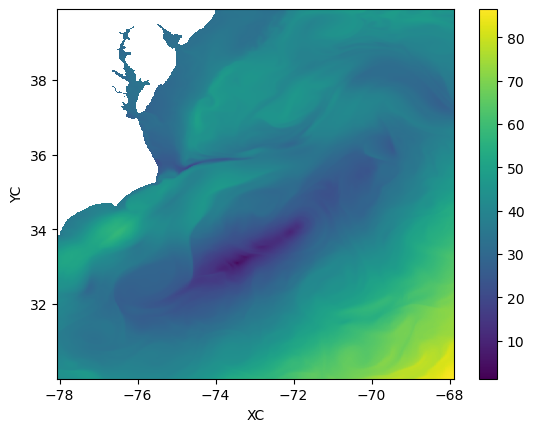

In [14]:
f = xr.apply_ufunc(gsw.f, xr.DataArray(dss.nav_lat.data, dims=['YC','XC'],
                                       coords={'YC':ds.YC,'XC':ds.XC}),
                   dask='parallelized'
                  )
hEk = (.7*ustar / f)
hEk.isel(time=62).plot()

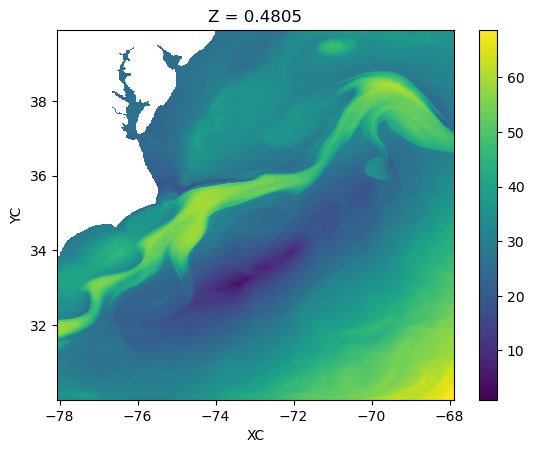

In [15]:
wstar = (-B0/hEk)**(1/3)

mstar = .5
nstar = .066
hEbl = (0.7 
        * np.sqrt((mstar*ustar**3 + nstar*wstar**3)**(2/3))
        / f)
hEbl.isel(time=62).plot()

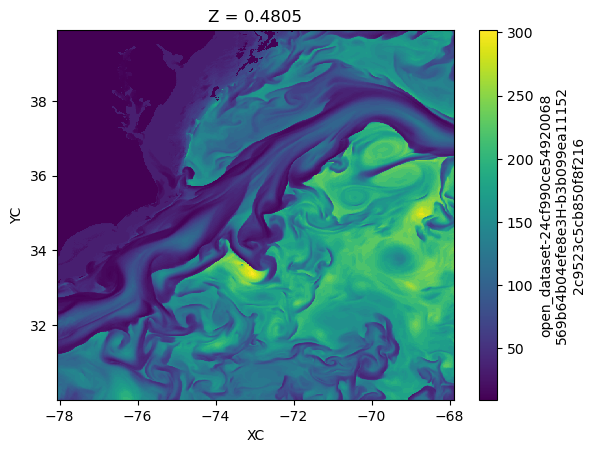

In [16]:
dz = xr.DataArray(dsi.e3t_0.mean(['y','x']).data, dims='Z',
                  coords={'Z':ds.Z}
                 ).load()
H = xr.open_zarr(op.join(sdir,'eNATL60/region%02d/MLD_fma.zarr' 
                         % reg)
                ).H.reset_coords(drop=True)
H = xr.DataArray(H.data, dims=ds.CT.isel(Z=0).dims, coords=ds.CT.isel(Z=0).coords)
H.isel(time=0).plot()

In [17]:
# pres = xr.apply_ufunc(gsw.p_from_z, -ds.Zp1, ds.lat, dask='parallelized'
#                      ).compute()
# for i in range(len(ds.time)):
#     n2, _ = gsw.Nsquared(
#                      grid.interp(ds.SA.isel(time=i).chunk({'Z':-1}),
#                                  'Z',boundary='extend'),
#                      grid.interp(ds.CT.isel(time=i).chunk({'Z':-1}),
#                                  'Z',boundary='extend'),
#                      pres,
#                      lat=ds.lat, axis=0
#                         )
#     if i == 0:
#         N2 = xr.DataArray(n2, dims=ds.CT.isel(time=i).dims, 
#                           coords=ds.CT.isel(time=i).coords
#                          ).chunk({'Z':3,'YC':100,'XC':100})
#     else:
#         N2 = xr.concat([N2, xr.DataArray(n2, dims=ds.CT.isel(time=i).dims, 
#                                          coords=ds.CT.isel(time=i).coords
#                                         ).chunk({'Z':3,'YC':100,'XC':100})
#                        ], 'time')
#     print(i)
# N2.chunk({'time':1}).to_dataset(name='N2'
#                                ).to_zarr(op.join(sdir,'eNATL60/region%02d/N2_fma.zarr' 
#                          % reg))
# ################
N2 = xr.open_zarr(op.join(sdir,'eNATL60/region%02d/N2_fma.zarr' 
                          % reg)
                 ).N2

N2 = ( (N2 * dz).where(N2.Z<=H).sum('Z',skipna=True) 
       / H ).compute().chunk({'time':1})
N2

<xarray.DataArray (time: 89, YC: 763, XC: 611)>
dask.array<xarray-<this-array>, shape=(89, 763, 611), dtype=float64, chunksize=(1, 763, 611), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 -78.06 -78.04 -78.02 -78.01 ... -67.93 -67.91 -67.9
  * YC       (YC) float32 30.01 30.02 30.04 30.05 ... 39.85 39.86 39.87 39.89
    lat      (YC, XC) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    lon      (YC, XC) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    Z        float32 0.4805
    maskC    (YC, XC) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
Dimensions without coordinates: time

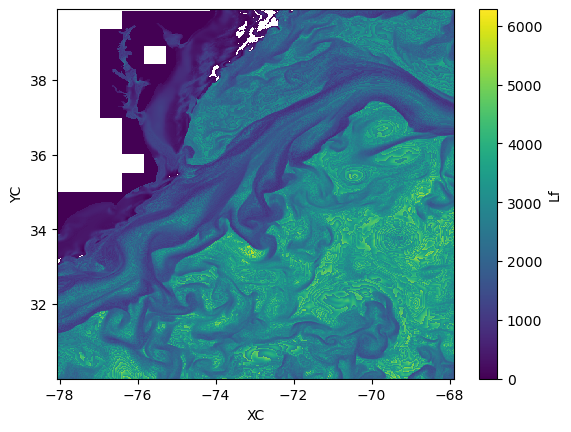

In [41]:
Cl = .25

# Lf_old = np.sqrt(N2) * H / f
# Lf_old.chunk({'time':1,'YC':100,'XC':100}
#             ).to_dataset(name='Lf'
#                         ).to_zarr(op.join(sdir,
#                                   'eNATL60/region%02d/MLradii_fma.zarr' 
#                           % reg), mode='w')
Lf_old = xr.open_zarr(op.join(sdir,
                        'eNATL60/region%02d/MLradii_fma.zarr' 
                              % reg)).Lf
Lf_Ek  = (mstar*ustar**3 + nstar*wstar**3)**(2/3) / f**2 / hEk
Lf_Ebl = (mstar*ustar**3 + nstar*wstar**3)**(2/3) / f**2 / hEbl
Lf_old.isel(time=0).plot()

In [ ]:
sig0 = xr.apply_ufunc(gsw.sigma0, ds.SA, ds.CT,
                      dask='parallelized', output_dtypes=[float,]
                     )
rho0 = 1e3
b = -(sig0.where(ds.maskC!=0.).chunk({'time':1,'Z':3,
                                      'YC':100,'XC':100}) 
      * grav / rho0
     )
b.to_dataset(name='BUOY').to_zarr(op.join(sdir,'eNATL60/region%02d/Buoy_fma.zarr' 
                                          % reg))

In [19]:
b = xr.open_zarr(op.join(sdir,'eNATL60/region%02d/Buoy_fma.zarr' 
                         % reg)
                ).BUOY
w = grid.interp(ds.W.chunk({'Zp1':-1}),'Z',boundary='extend'
               ).chunk({'time':1,'Z':3,'YC':100,'XC':100})
area = xr.DataArray((dss.e1t * dss.e2t).data, dims=['YC','XC'],
                    coords={'YC':YC.data,'XC':XC.data}
                   )

# Filter, then coarsen

In [20]:
nC = 15
yC = ds.YC.isel(YC=slice(1,-1)).coarsen({'YC':nC},boundary='trim').mean(skipna=True)
xC = ds.XC.isel(XC=slice(1,-1)).coarsen({'XC':nC},boundary='trim').mean(skipna=True)
yG = ds.YG.isel(YG=slice(1,-1)).coarsen({'YG':nC},boundary='trim').mean(skipna=True)
xG = ds.XG.isel(XG=slice(1,-1)).coarsen({'XG':nC},boundary='trim').mean(skipna=True)
aC = area.where(ds.maskC.isel(Z=0)!=0.).isel(YC=slice(1,-1),XC=slice(1,-1)
                                  ).coarsen({'YC':nC,'XC':nC},boundary='trim'
                                           ).sum(skipna=True).compute()

In [21]:
dxw = xr.DataArray(dss.e1u.data, dims=['YC','XC'],
                   coords={'YC':YC.data, 'XC':XC.data}
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(dss.e2u.data, dims=['YC','XC'],
                   coords={'YC':YC.data, 'XC':XC.data}
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(dss.e1v.data, dims=['YC','XC'],
                   coords={'YC':YC.data, 'XC':XC.data}
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(dss.e2v.data, dims=['YC','XC'],
                   coords={'YC':YC.data, 'XC':XC.data}
                  ) # y-spacing centered at southern cell edge

dx_min = min(dss.e1u.min(['y','x']), dss.e2u.min(['y','x']),
             dss.e1v.min(['y','x']), dss.e2v.min(['y','x'])
            )
dx_min = dx_min.values

wet_mask = xr.zeros_like(ds.CT.isel(time=0)
           ).chunk({'Z':1})
wet_mask[:,1:-1,1:-1] = dsi.tmask[:,1:-1,1:-1].data.astype(np.float64)

kappa_w = xr.zeros_like(wet_mask).chunk({'Z':1})
kappa_w[:,1:-1,1:-1] += 1.
kappa_s = xr.zeros_like(wet_mask).chunk({'Z':1})
kappa_s[:,1:-1,1:-1] += 1.


filter_30km = gcm_filters.Filter(
    filter_scale=3e4,   # 30 km
    dx_min=dx_min,
#     n_steps=36,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.chunk({'YC':-1,'XC':-1}), 
        'dxw': dxw.chunk({'YC':-1,'XC':-1}), 'dyw': dyw.chunk({'YC':-1,'XC':-1}), 
        'dxs': dxs.chunk({'YC':-1,'XC':-1}), 'dys': dys.chunk({'YC':-1,'XC':-1}), 
        'area': area.chunk({'YC':-1,'XC':-1}), 
        'kappa_w': kappa_w.chunk({'YC':-1,'XC':-1}), 
        'kappa_s': kappa_s.chunk({'YC':-1,'XC':-1})
    }
)

In [21]:
wm = filter_30km.apply(w.chunk({'YC':-1,'XC':-1}), 
                       dims=['YC', 'XC']
                      ).isel(YC=slice(1,-1),XC=slice(1,-1)
                            ).reset_coords(drop=True).chunk({'YC':100,'XC':100})
bm = filter_30km.apply(b.chunk({'YC':-1,'XC':-1}), 
                       dims=['YC', 'XC']
                      ).isel(YC=slice(1,-1),XC=slice(1,-1)
                            ).reset_coords(drop=True).chunk({'YC':100,'XC':100})
dsave = wm.to_dataset(name='WVEL')
dsave['BUOY'] = bm
dsave.to_zarr(op.join(sdir,'eNATL60/region%02d/Meso_W-B.zarr' 
                      % reg), mode='w')

In [22]:
dsm = xr.open_zarr(op.join(sdir,'eNATL60/region%02d/Meso_W-B.zarr' 
                           % reg))
ws = (w.isel(YC=slice(1,-1),XC=slice(1,-1))
      - dsm.WVEL).reset_coords(drop=True).chunk({'Z':3,'YC':100,'XC':100})
bs = (b.isel(YC=slice(1,-1),XC=slice(1,-1)) 
      - dsm.BUOY).reset_coords(drop=True).chunk({'Z':3,'YC':100,'XC':100})
bs

<xarray.DataArray 'BUOY' (time: 89, Z: 106, YC: 761, XC: 609)>
dask.array<rechunk-merge, shape=(89, 106, 761, 609), dtype=float64, chunksize=(1, 3, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 -78.04 -78.02 -78.01 -77.99 ... -67.95 -67.93 -67.91
  * YC       (YC) float32 30.02 30.04 30.05 30.07 ... 39.84 39.85 39.86 39.87
  * Z        (Z) float32 0.4805 1.559 2.794 4.187 ... 934.9 951.6 968.4 985.3
Dimensions without coordinates: time

In [36]:
dswb = ws.to_dataset(name='ws')
dswb['bs'] = bs
dswb.coords['DXU'] = xr.DataArray(dss.e1u.isel(y=slice(1,-1),x=slice(1,-1)),
                   dims=['YC','XG'], 
                   coords={'YC':ds.YC.isel(YC=slice(1,-1)),
                           'XG':ds.XG.isel(XG=slice(1,-1))}
                  )
dswb.coords['DYV'] = xr.DataArray(dss.e2v.isel(y=slice(1,-1),x=slice(1,-1)),
                   dims=['YG','XC'], 
                   coords={'YG':ds.YG.isel(YG=slice(1,-1)),
                           'XC':ds.XC.isel(XC=slice(1,-1))}
                  )
dswb.coords['DXT'] = xr.DataArray(dss.e1t.isel(y=slice(1,-1),x=slice(1,-1)),
                   dims=['YC','XC'], 
                   coords={'YC':ds.YC.isel(YC=slice(1,-1)),
                           'XC':ds.XC.isel(XC=slice(1,-1))}
                  )
dswb.coords['DYT'] = xr.DataArray(dss.e2t.isel(y=slice(1,-1),x=slice(1,-1)),
                   dims=['YC','XC'], 
                   coords={'YC':ds.YC.isel(YC=slice(1,-1)),
                           'XC':ds.XC.isel(XC=slice(1,-1))}
                  )

coords={
        "X": {"center": "XC", "left": "XG"},
        "Y": {"center": "YC", "left": "YG"},
       }
grids = Grid(dswb, periodic=[],
             coords=coords)

xT = grids.cumsum(dswb.DXU, 'X', boundary='extend')
yT = grids.cumsum(dswb.DYV, 'Y', boundary='extend')

ny, nx = xT.shape
xT = xT - xT.isel(XC=nx//2)
xT = (xT - xT.isel(YC=-1,XC=0)).values.flatten()
yT = (yT - yT.isel(YC=0)).values.flatten()

dx = dswb.DXT.min().values
dy = dswb.DYT.min().values

In [37]:
ws_terp = xr.DataArray(np.zeros_like(ws[::14,1::2].sel(Z=slice(None,200))), 
                       dims=ws.dims,
                       coords={'Z':ws.Z[1::2].sel(Z=slice(None,200)).data,
                               'YC':np.arange(0,ny*dy,dy),
                               'XC':np.arange(0,nx*dx,dx)}
                      )
bs_terp = xr.DataArray(np.zeros_like(bs[::14,1::2].sel(Z=slice(None,200))), 
                       dims=bs.dims,
                       coords={'Z':bs.Z[1::2].sel(Z=slice(None,200)).data,
                               'YC':np.arange(0,ny*dy,dy),
                               'XC':np.arange(0,nx*dx,dx)}
                      )

xxx, yyy = np.mgrid[0:nx*dx:dx, 0:ny*dy:dy]

for nn in range(len(dswb.time[::14])):
    for iz in range(len(ws_terp.Z)):
        ws_terp[dict(time=nn,Z=iz)
               ] = griddata((xT, yT), 
                            (ws[::14,1::2]
                             * area.isel(YC=slice(1,-1),XC=slice(1,-1))
                            ).isel(time=nn,Z=iz).values.flatten(),
                            (xxx, yyy) 
                           ).T
        bs_terp[dict(time=nn,Z=iz)
               ] = griddata((xT, yT), 
                            (bs[::14,1::2]
                             * area.isel(YC=slice(1,-1),XC=slice(1,-1))
                            ).isel(time=nn,Z=iz).values.flatten(),
                            (xxx, yyy) 
                           ).T
    print(nn)

ws_terp /= griddata((xT, yT), 
                    area.isel(YC=slice(1,-1),XC=slice(1,-1)
                             ).values.flatten(),
                    (xxx, yyy) 
                   ).T[np.newaxis,np.newaxis,:,:]
bs_terp /= griddata((xT, yT), 
                    area.isel(YC=slice(1,-1),XC=slice(1,-1)
                             ).values.flatten(),
                    (xxx, yyy) 
                   ).T[np.newaxis,np.newaxis,:,:]

0
1
2
3
4
5
6


In [38]:
dsave = ws_terp.to_dataset(name='Ws')
dsave['Bs'] = bs_terp
dsave.chunk({'time':1}).to_zarr(op.join(sdir,
                                'eNATL60/region%02d/WsBs_interp.zarr' 
                                        % (reg)),
                                mode='w')

In [23]:
dwsbs = xr.open_zarr(op.join(sdir,
                             'eNATL60/region%02d/WsBs_interp.zarr' 
                             % (reg))
                    )
Cwsbs = xrft.isotropic_cross_spectrum(dwsbs.Ws.sel(YC=slice(None,8e5),
                                               XC=slice(4e5,None)
                                              ).fillna(0.).chunk({'time':1}),
                                    dwsbs.Bs.sel(YC=slice(None,8e5),
                                               XC=slice(4e5,None)
                                              ).fillna(0.).chunk({'time':1}),
                                    dim=['YC','XC'],
                                    detrend='constant',
                                    window='hann', window_correction=True,
                                    truncate=True
                                   )
Cwsbs

<xarray.DataArray (time: 7, Z: 22, freq_r: 54)>
dask.array<getitem, shape=(7, 22, 54), dtype=complex128, chunksize=(1, 22, 54), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) float32 1.559 4.187 7.449 11.35 ... 148.3 162.8 177.9 193.6
  * freq_r   (freq_r) float64 4.029e-06 9.747e-06 ... 0.0003387 0.0003452
Dimensions without coordinates: time

In [24]:
CwsbsH = (Cwsbs.sel(Z=slice(None,100)
                   ) * dz.sel(Z=slice(None,110)
                             )[1:].coarsen({'Z':2},boundary='trim'
                                     ).sum(skipna=True
                                          ).data[np.newaxis,:,np.newaxis]
         ).sum('Z',skipna=True) / 1e2

In [24]:
dt = 1
for i in np.arange(0,len(dsm.time),dt):
    # tend = i + dt
    # if tend > len(dsm.time)-1:
    #     tend = None
    wsbs = ((((ws*bs).isel(time=i)
              * dz
             ).where(ds.Z<=H.isel(time=i,YC=slice(1,-1),XC=slice(1,-1)))
            ).sum('Z',skipna=True)
            / H.isel(time=i,YC=slice(1,-1),XC=slice(1,-1))
           ).reset_coords(drop=True).chunk({'YC':100,'XC':100})
    if i == 0:
        wsbsb = xr.DataArray(((wsbs
                               * area.isel(YC=slice(1,-1),XC=slice(1,-1))
                      ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
                      / aC
                     ).data,
                     dims=['YC','XC'], 
                     coords={'YC':yC,'XC':xC}
          ).compute()
    else:
        wsbsb = xr.concat([wsbsb, 
                           xr.DataArray(((wsbs
                                          * area.isel(YC=slice(1,-1),XC=slice(1,-1))
                      ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
                      / aC
                     ).data,
                     dims=['YC','XC'], 
                     coords={'YC':yC,'XC':xC}
          ).compute()], 'time')
    print(i)

wsbsb.to_dataset(name='WsBs').chunk({'time':1}
                                   ).to_zarr(op.join(sdir,
                                            'eNATL60/region%02d/Coarse/nC%02d/WsBsH.zarr' 
                                                     % (reg,nC)),
                                             mode='w')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88


In [26]:
dt = 1
for i in np.arange(0,len(dsm.time),dt):
    # tend = i + dt
    # if tend > len(dsm.time)-1:
    #     tend = None
    wsH = ((((ws).isel(time=i)
              * dz
             ).where(ds.Z<=H.isel(time=i,YC=slice(1,-1),XC=slice(1,-1)))
            ).sum('Z',skipna=True)
            / H.isel(time=i,YC=slice(1,-1),XC=slice(1,-1))
           ).reset_coords(drop=True).chunk({'YC':100,'XC':100})
    bsH = ((((bs).isel(time=i)
              * dz
             ).where(ds.Z<=H.isel(time=i,YC=slice(1,-1),XC=slice(1,-1)))
            ).sum('Z',skipna=True)
            / H.isel(time=i,YC=slice(1,-1),XC=slice(1,-1))
           ).reset_coords(drop=True).chunk({'YC':100,'XC':100})
    if i == 0:
        wsHb = xr.DataArray(((wsH
                               * area.isel(YC=slice(1,-1),XC=slice(1,-1))
                      ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
                      / aC
                     ).data,
                     dims=['YC','XC'], 
                     coords={'YC':yC,'XC':xC}
          ).compute()
        bsHb = xr.DataArray(((bsH
                               * area.isel(YC=slice(1,-1),XC=slice(1,-1))
                      ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
                      / aC
                     ).data,
                     dims=['YC','XC'], 
                     coords={'YC':yC,'XC':xC}
          ).compute()
    else:
        wsHb = xr.concat([wsHb, 
                           xr.DataArray(((wsH
                                          * area.isel(YC=slice(1,-1),XC=slice(1,-1))
                      ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
                      / aC
                     ).data,
                     dims=['YC','XC'], 
                     coords={'YC':yC,'XC':xC}
          ).compute()], 'time')
        bsHb = xr.concat([bsHb, 
                           xr.DataArray(((bsH
                                          * area.isel(YC=slice(1,-1),XC=slice(1,-1))
                      ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
                      / aC
                     ).data,
                     dims=['YC','XC'], 
                     coords={'YC':yC,'XC':xC}
          ).compute()], 'time')
    print(i)

dsave = wsHb.to_dataset(name='Ws')
dsave['Bs'] = bsHb
dsave.chunk({'time':1}).to_zarr(op.join(sdir,
                                        'eNATL60/region%02d/Coarse/nC%02d/WsHBsH.zarr' 
                                        % (reg,nC)),
                                mode='w')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88


In [25]:
dt = 1
for i in np.arange(0,len(dsm.time),dt):
    # tend = i + dt
    # if tend > len(dsm.time)-1:
    #     tend = None
    if i == 0:
        bmb = xr.DataArray(((dsm.BUOY.isel(time=i)
                             * area.isel(YC=slice(1,-1),XC=slice(1,-1))
                    ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
                    / aC
                   ).data,
                   dims=['Z','YC','XC'], 
                   coords={'Z':ds.Z,'YC':yC,'XC':xC}
        ).compute().chunk({'YC':-1,'XC':-1,'Z':3})
    else:
        bmb = xr.concat([bmb,
                         xr.DataArray(((dsm.BUOY.isel(time=i)
                                        * area.isel(YC=slice(1,-1),XC=slice(1,-1))
                    ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
                    / aC
                   ).data,
                   dims=['Z','YC','XC'], 
                   coords={'Z':ds.Z,'YC':yC,'XC':xC}
        ).compute().chunk({'YC':-1,'XC':-1,'Z':3})], 'time')
    print(i)

bmb.to_dataset(name='BUOY').chunk({'time':1}
                                 ).to_zarr(op.join(sdir,
                                                'eNATL60/region%02d/Coarse/nC%02d/Bm.zarr' 
                                                   % (reg,nC)),
                                           mode='w')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88


In [25]:
dsC = xr.merge([xr.merge([xr.open_zarr(
                op.join(sdir,'eNATL60/region%02d/Coarse/nC%02d/Bm.zarr' 
                                     % (reg,nC))
                            ),
                xr.open_zarr(op.join(sdir,'eNATL60/region%02d/Coarse/nC%02d/WsBsH.zarr'
                                     % (reg,nC))
                            )]),
                xr.open_zarr(op.join(sdir,'eNATL60/region%02d/Coarse/nC%02d/WsHBsH.zarr'
                                     % (reg,nC))
                            )
               ])
dsC

<xarray.Dataset>
Dimensions:  (time: 89, Z: 106, YC: 50, XC: 40)
Coordinates:
  * XC       (XC) float32 -77.92 -77.67 -77.42 -77.17 ... -68.68 -68.43 -68.18
  * YC       (YC) float32 30.12 30.33 30.54 30.75 ... 39.12 39.3 39.48 39.66
  * Z        (Z) float32 0.4805 1.559 2.794 4.187 ... 934.9 951.6 968.4 985.3
Dimensions without coordinates: time
Data variables:
    BUOY     (time, Z, YC, XC) float64 dask.array<chunksize=(1, 3, 50, 40), meta=np.ndarray>
    WsBs     (time, YC, XC) float64 dask.array<chunksize=(1, 50, 40), meta=np.ndarray>
    Bs       (time, YC, XC) float64 dask.array<chunksize=(1, 50, 40), meta=np.ndarray>
    Ws       (time, YC, XC) float64 dask.array<chunksize=(1, 50, 40), meta=np.ndarray>

In [26]:
lonC = ((xr.DataArray(dss.lon.data, dims=['YC','XC'],
                      coords={'YC':ds.YC,'XC':ds.XC}
                     ) * area
        ).isel(YC=slice(1,-1),XC=slice(1,-1)
              ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
        / area.isel(YC=slice(1,-1),XC=slice(1,-1)
                   ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
       )
latC = ((xr.DataArray(dss.lat.data, dims=['YC','XC'],
                      coords={'YC':ds.YC,'XC':ds.XC}
                     ) * area
        ).isel(YC=slice(1,-1),XC=slice(1,-1)
              ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
        / area.isel(YC=slice(1,-1),XC=slice(1,-1)
                   ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
       )
fb = xr.DataArray(xr.apply_ufunc(gsw.f, latC,
                                 dask='parallelized'
                                ).data, 
                  dims=['YC','XC'],
                  coords={'YC':yC,'XC':xC}
                 )
dsC.coords['DXU'] = xr.DataArray(dss.e1u.isel(x=slice(1,-1)
                                             ).coarsen({'x':nC},
                                   boundary='trim').sum(skipna=True
                                                       ).isel(y=slice(1,-1)
                                             ).coarsen({'y':nC},
                                   boundary='trim').mean(skipna=True
                                                       ),
                   dims=['YC','XG'], 
                   coords={'YC':yC,'XG':xG}
                  )
dsC.coords['DYU'] = xr.DataArray(dss.e2u.isel(y=slice(1,-1)
                                             ).coarsen({'y':nC},
                                   boundary='trim').sum(skipna=True
                                                       ).isel(x=slice(1,-1)
                                             ).coarsen({'x':nC},
                                   boundary='trim').mean(skipna=True
                                                       ),
                   dims=['YC','XG'], 
                   coords={'YC':yC,'XG':xG}
                  )
dsC.coords['DXV'] = xr.DataArray(dss.e1v.isel(x=slice(1,-1)
                                             ).coarsen({'x':nC},
                                   boundary='trim').sum(skipna=True
                                                       ).isel(y=slice(1,-1)
                                             ).coarsen({'y':nC},
                                   boundary='trim').mean(skipna=True
                                                       ),
                   dims=['YG','XC'], 
                   coords={'YG':yG,'XC':xC}
                  )
dsC.coords['DYV'] = xr.DataArray(dss.e2v.isel(y=slice(1,-1)
                                             ).coarsen({'y':nC},
                                   boundary='trim').sum(skipna=True
                                                       ).isel(x=slice(1,-1)
                                             ).coarsen({'x':nC},
                                   boundary='trim').mean(skipna=True
                                                       ),
                   dims=['YG','XC'], 
                   coords={'YG':yG,'XC':xC}
                  )
dsC.coords['DXT'] = xr.DataArray(dss.e1t.isel(x=slice(1,-1)
                                             ).coarsen({'x':nC},
                                   boundary='trim').sum(skipna=True
                                                       ).isel(y=slice(1,-1)
                                             ).coarsen({'y':nC},
                                   boundary='trim').mean(skipna=True
                                                       ),
                   dims=['YC','XC'], 
                   coords={'YC':yC,'XC':xC}
                  )
dsC.coords['DYT'] = xr.DataArray(dss.e2t.isel(y=slice(1,-1)
                                             ).coarsen({'y':nC},
                                   boundary='trim').sum(skipna=True
                                                       ).isel(x=slice(1,-1)
                                             ).coarsen({'x':nC},
                                   boundary='trim').mean(skipna=True
                                                       ),
                   dims=['YC','XC'], 
                   coords={'YC':yC,'XC':xC}
                  )
dsC.coords['DXF'] = xr.DataArray(dss.e1f.isel(x=slice(1,-1)
                                             ).coarsen({'x':nC},
                                   boundary='trim').sum(skipna=True
                                                       ).isel(y=slice(1,-1)
                                             ).coarsen({'y':nC},
                                   boundary='trim').mean(skipna=True
                                                       ),
                   dims=['YG','XG'], 
                   coords={'YG':yG,'XG':xG}
                  )
dsC.coords['DYF'] = xr.DataArray(dss.e2f.isel(y=slice(1,-1)
                                             ).coarsen({'y':nC},
                                   boundary='trim').sum(skipna=True
                                                       ).isel(x=slice(1,-1)
                                             ).coarsen({'x':nC},
                                   boundary='trim').mean(skipna=True
                                                       ),
                   dims=['YG','XG'], 
                   coords={'YG':yG,'XG':xG}
                  )

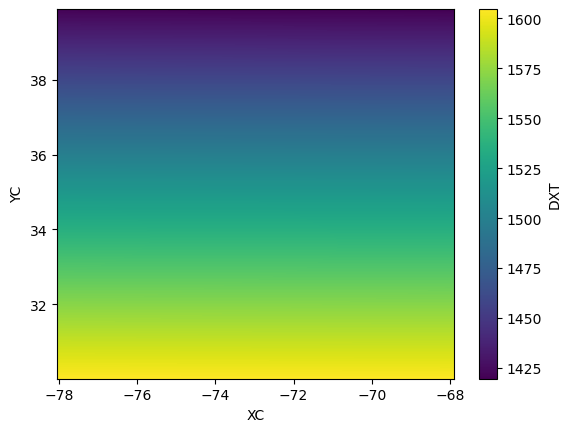

In [54]:
dswb.DXT.plot()

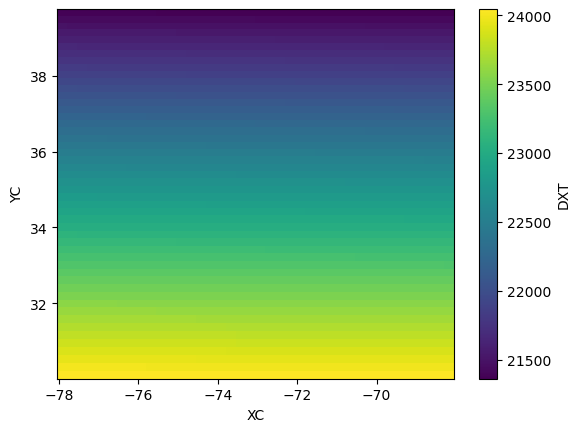

In [57]:
dsC.DXT.plot()

In [27]:
coords={
        "X": {"center": "XC", "left": "XG"},
        "Y": {"center": "YC", "left": "YG"},
        # "Z": {"center": "Z",  "outer":"Zp1"}
       }
gridC = Grid(dsC, periodic=[],
             coords=coords)

In [42]:
Hb = xr.DataArray((H*area).where(ds.maskC.isel(Z=0)!=0.
                                ).isel(YC=slice(1,-1),XC=slice(1,-1)
                               ).coarsen({'YC':nC,'XC':nC},
                                         boundary='trim').sum(skipna=True)
      / aC,
                  dims=['time','YC','XC'], 
                  coords={'time':ds.time,'YC':yC,'XC':xC}
     ).chunk({'YC':-1,'XC':-1})
Lf_oldb = xr.DataArray((Lf_old*area).where(ds.maskC.isel(Z=0)!=0.
                                          ).isel(YC=slice(1,-1),XC=slice(1,-1)
                            ).coarsen({'YC':nC,'XC':nC},
                                      boundary='trim').sum(skipna=True)
      / aC,
                  dims=['time','YC','XC'], 
                  coords={'time':ds.time,'YC':yC,'XC':xC}
     ).chunk({'YC':-1,'XC':-1})
Lf_Ekb = xr.DataArray((Lf_Ek*area).where(ds.maskC.isel(Z=0)!=0.
                                        ).isel(YC=slice(1,-1),XC=slice(1,-1)
                            ).coarsen({'YC':nC,'XC':nC},
                                      boundary='trim').sum(skipna=True)
      / aC,
                  dims=['time','YC','XC'], 
                  coords={'time':ds.time,'YC':yC,'XC':xC}
     ).chunk({'YC':-1,'XC':-1})
Lf_Eblb = xr.DataArray((Lf_Ebl*area).where(ds.maskC.isel(Z=0)!=0.
                                        ).isel(YC=slice(1,-1),XC=slice(1,-1)
                            ).coarsen({'YC':nC,'XC':nC},
                                      boundary='trim').sum(skipna=True)
      / aC,
                  dims=['time','YC','XC'], 
                  coords={'time':ds.time,'YC':yC,'XC':xC}
     ).chunk({'YC':-1,'XC':-1})
Db = xr.DataArray((dss.depth.data
                   * area).where(ds.maskC.isel(Z=0)!=0.
                                ).isel(YC=slice(1,-1),XC=slice(1,-1)
                                            ).coarsen({'YC':nC,'XC':nC},
                                                      boundary='trim'
                                                     ).sum(skipna=True)
      / aC,
                  dims=['YC','XC'], 
                  coords={'YC':yC,'XC':xC}
     ).chunk({'YC':-1,'XC':-1})

B_x = ((gridC.interp(gridC.diff(dsC.BUOY,'X',boundary='extend') 
                     / dsC.DXU,
                     'X',boundary='extend')
        * dz
       ).where(dsC.Z<=Hb).sum('Z',skipna=True
                             ).reset_coords(drop=True).chunk({'YC':-1,'XC':-1})
       / Hb)
B_y = ((gridC.interp(gridC.diff(dsC.BUOY,'Y',boundary='extend') 
                     / dsC.DYV,
                     'Y',boundary='extend')
        * dz
       ).where(dsC.Z<=Hb).sum('Z',skipna=True
                             ).reset_coords(drop=True).chunk({'YC':-1,'XC':-1}) 
       / Hb)

Text(0.5, 1.0, '$L_f^{\\tt Ek}$')

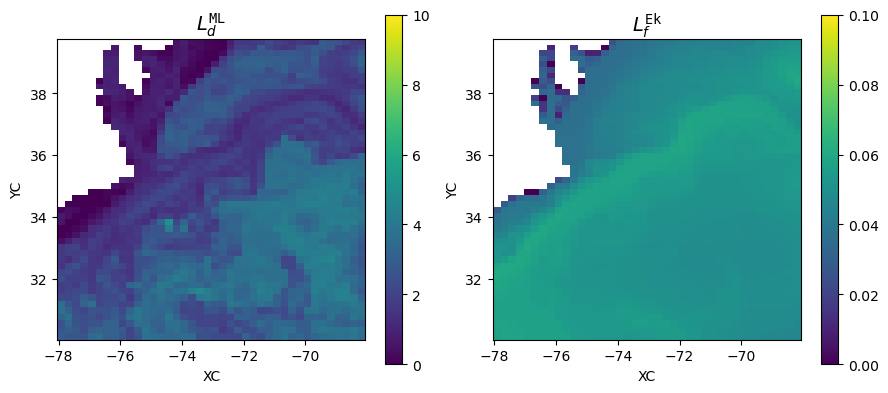

In [43]:
fig, (ax1,ax2) = plt.subplots(figsize=(9,4), nrows=1, ncols=2)
fig.set_tight_layout(True)

(Lf_oldb.isel(time=16)*1e-3).plot(ax=ax1, vmax=1e1, rasterized=True)
(Lf_Ekb.isel(time=16)*Cl*1e-3).plot(ax=ax2, vmax=.1e0, rasterized=True)

ax1.set_aspect('equal')
ax2.set_aspect('equal')

ax1.set_title(r"$L_d^{\tt ML}$", fontsize=14)
ax2.set_title(r"$L_f^{\tt Ek}$", fontsize=14)

In [44]:
Psix_old = np.sqrt(aC)/Lf_oldb/fb * Hb**2 * B_y
Psiy_old = np.sqrt(aC)/Lf_oldb/fb * Hb**2 * (-B_x)
Psix_Ek = np.sqrt(aC)/Lf_Ekb/fb * Hb**2 * B_y
Psiy_Ek = np.sqrt(aC)/Lf_Ekb/fb * Hb**2 * (-B_x)
Psix_Ebl = np.sqrt(aC)/Lf_Eblb/fb * Hb**2 * B_y
Psiy_Ebl = np.sqrt(aC)/Lf_Eblb/fb * Hb**2 * (-B_x)
Psix_old

<xarray.DataArray (YC: 50, XC: 40, time: 89)>
dask.array<mul, shape=(50, 40, 89), dtype=float64, chunksize=(50, 40, 1), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float32 30.12 30.33 30.54 30.75 ... 39.12 39.3 39.48 39.66
  * XC       (XC) float32 -77.92 -77.67 -77.42 -77.17 ... -68.68 -68.43 -68.18
    Z        float32 0.4805
    lat      (YC, XC) float32 30.11 30.11 30.11 30.11 ... 39.75 39.76 39.76
    lon      (YC, XC) float32 -77.87 -77.62 -77.38 ... -68.78 -68.53 -68.28
    maskC    (YC, XC) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 79 80 81 82 83 84 85 86 87 88

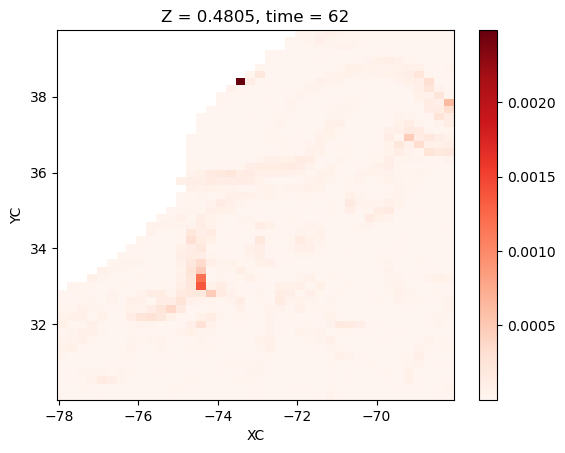

In [45]:
bff    = (Psix_old*B_y - Psiy_old*B_x)
bodEk  = (Psix_Ek*B_y  - Psiy_Ek*B_x )
bodEbl = (Psix_Ebl*B_y - Psiy_Ebl*B_x)
bodEbl.where(Db>2e2).isel(time=62).plot(cmap='Reds')

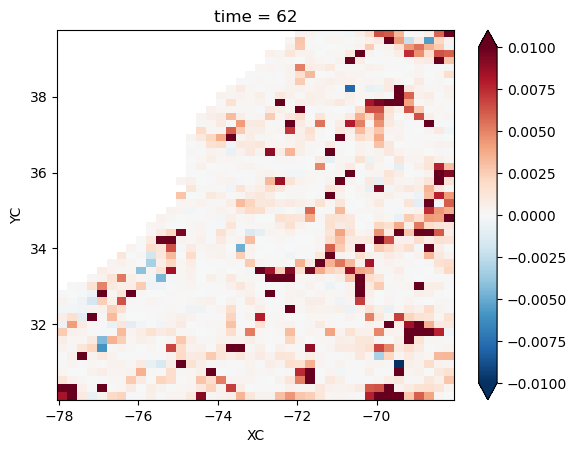

In [46]:
Ce    = (dsC.WsBs / bff   ).where(Db>2e2).reset_coords(drop=True)
CrEk  = (dsC.WsBs / bodEk ).where(Db>2e2).reset_coords(drop=True)
CrEbl = (dsC.WsBs / bodEbl).where(Db>2e2).reset_coords(drop=True)
CrEk.isel(time=62).plot(vmax=1e-2)

In [47]:
CeC    = Ce.median(['YC','XC'],skipna=True).compute()
CrEkC  = CrEk.median(['YC','XC'],skipna=True).compute()
CrEblC = CrEbl.median(['YC','XC'],skipna=True).compute()

In [48]:
CeC.mean('time'), CrEkC.mean('time')

(<xarray.DataArray ()>
 array(0.00864827),
 <xarray.DataArray ()>
 array(0.00064514))

In [49]:
time = np.arange('2010-02-01', '2010-05-01', 
                 dtype='datetime64[D]')

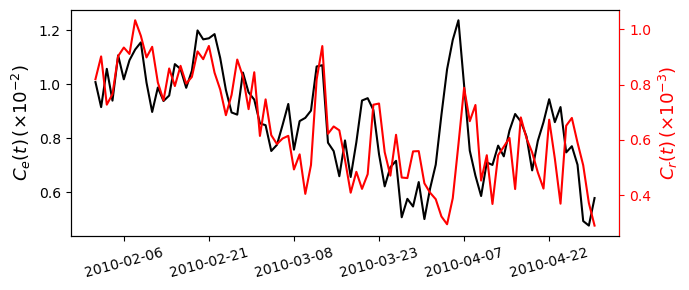

In [50]:
fig, ax = plt.subplots(figsize=(7,3))
fig.set_tight_layout(True)
ax2 = ax.twinx()
ax.plot(range(89), CeC.values*1e2, 'k', label=r"$C_e(t)$")
ax2.plot(range(89), CrEkC.values*1e3, 'r', label=r"$h=h_{Ek}$")
# ax2.plot(range(89), CrEblC.values, 'm--', label=r"$h=h_{ePBL}$")
ax.set_xticks(np.arange(89)[5::15])
ax.set_xticklabels(time[5::15], rotation=15)
ax2.yaxis.label.set_color('red')         #setting up Y-axis label color to blue
ax2.tick_params(axis='y', colors='red')  #setting up Y-axis tick color to black
ax2.spines['right'].set_color('red')
# ax.legend(loc='lower left', fontsize=12)
# ax2.legend(loc='upper right', fontsize=12)
ax.set_ylabel(r"$C_e(t)\,(\times 10^{-2})$", fontsize=13)
ax2.set_ylabel(r"$C_r(t)\,(\times 10^{-3})$", fontsize=13)
plt.savefig(op.join(sdir,'Figs/eNATL60_region%02d_nC%02d_Cs.pdf' 
                    % (reg,nC)))

In [51]:
cbodEk = (bodEk*CrEkC).where(Db>2e2)
# cbodEbl = (bodEbl*CrEblC).where(Db>2e2)
cbff = (bff*CeC).where(Db>2e2)
WsBs = dsC.WsBs.where(Db>2e2)
CbodEk = (bodEk*CrEkC.mean('time')).where(Db>2e2)
# cbodEbl = (bodEbl*CrEblC).where(Db>2e2)
Cbff = (bff*CeC.mean('time')).where(Db>2e2)
cbodEk.name = 'Ekman'
# CbodEbl.name = 'ePBL'
cbff.name = 'BFF'
CbodEk.name = 'Ekman'
# CbodEbl.name = 'ePBL'
Cbff.name = 'BFF'
WsBs.name = 'Submeso'

In [52]:
xT = gridC.cumsum(dsC.DXU, 'X', boundary='extend')
yT = gridC.cumsum(dsC.DYV, 'Y', boundary='extend')

ny, nx = xT.shape
xT = xT - xT.isel(XC=nx//2)
xT = (xT - xT.isel(YC=-1,XC=0)).values.flatten()
yT = (yT - yT.isel(YC=0)).values.flatten()

dx = dsC.DXT.min().values
dy = dsC.DYT.min().values

Ekterp = xr.DataArray(np.zeros_like(cbodEk[...,::14]), dims=cbodEk.dims,
                      coords={'YC':np.arange(0,ny*dy,dy),
                              'XC':np.arange(0,nx*dx,dx)}
                     )
bfterp = xr.DataArray(np.zeros_like(cbff[...,::14]), dims=cbff.dims,
                      coords={'YC':np.arange(0,ny*dy,dy),
                              'XC':np.arange(0,nx*dx,dx)}
                     )
wbterp = xr.DataArray(np.zeros_like(WsBs[::14]), dims=WsBs.dims,
                      coords={'YC':np.arange(0,ny*dy,dy),
                              'XC':np.arange(0,nx*dx,dx)}
                     )

xxx, yyy = np.mgrid[0:nx*dx:dx, 0:ny*dy:dy]

for nn in range(len(WsBs.time[::14])):
    Ekterp[dict(time=nn)] = griddata((xT, yT), 
                                     (cbodEk[...,::14]*aC
                                     ).isel(time=nn).values.flatten(),
                                     (xxx, yyy) 
                                    ).T 
    bfterp[dict(time=nn)] = griddata((xT, yT), 
                                     (cbff[...,::14]*aC
                                     ).isel(time=nn).values.flatten(),
                                     (xxx, yyy) 
                                    ).T
    wbterp[dict(time=nn)] = griddata((xT, yT), 
                                     (WsBs[::14]*aC
                                     ).isel(time=nn).values.flatten(),
                                     (xxx, yyy) 
                                    ).T


In [ ]:
xT = gridC.cumsum(dsC.DXU, 'X', boundary='extend')
yT = gridC.cumsum(dsC.DYV, 'Y', boundary='extend')

ny, nx = xT.shape
xT = xT - xT.isel(XC=nx//2)
xT = (xT - xT.isel(YC=-1,XC=0)).values.flatten()
yT = (yT - yT.isel(YC=0)).values.flatten()

dx = dsC.DXT.min().values
dy = dsC.DYT.min().values

Bx_terp = xr.DataArray(np.zeros_like(B_x[::14]), dims=B_x.dims,
                      coords={'YC':np.arange(0,ny*dy,dy),
                              'XC':np.arange(0,nx*dx,dx)}
                     )
By_terp = xr.DataArray(np.zeros_like(B_y[::14]), dims=B_y.dims,
                      coords={'YC':np.arange(0,ny*dy,dy),
                              'XC':np.arange(0,nx*dx,dx)}
                     )

xxx, yyy = np.mgrid[0:nx*dx:dx, 0:ny*dy:dy]

for nn in range(len(WsBs.time[::14])):
    Bx_terp[dict(time=nn)] = griddata((xT, yT), 
                                     (B_x[::14]*aC
                                     ).isel(time=nn).values.flatten(),
                                     (xxx, yyy) 
                                    ).T 
    By_terp[dict(time=nn)] = griddata((xT, yT), 
                                     (B_y[::14]*aC
                                     ).isel(time=nn).values.flatten(),
                                     (xxx, yyy) 
                                    ).T

In [ ]:
xT = gridC.cumsum(dsC.DXU, 'X', boundary='extend')
yT = gridC.cumsum(dsC.DYV, 'Y', boundary='extend')

ny, nx = xT.shape
xT = xT - xT.isel(XC=nx//2)
xT = (xT - xT.isel(YC=-1,XC=0)).values.flatten()
yT = (yT - yT.isel(YC=0)).values.flatten()

dx = dsC.DXT.min().values
dy = dsC.DYT.min().values

Psix_bfterp = xr.DataArray(np.zeros_like(Psix_old[...,::14]), dims=Psix_old.dims,
                      coords={'YC':np.arange(0,ny*dy,dy),
                              'XC':np.arange(0,nx*dx,dx)}
                     )
Psiy_bfterp = xr.DataArray(np.zeros_like(Psiy_old[...,::14]), dims=Psiy_old.dims,
                      coords={'YC':np.arange(0,ny*dy,dy),
                              'XC':np.arange(0,nx*dx,dx)}
                     )
Psix_Ekterp = xr.DataArray(np.zeros_like(Psix_Ek[...,::14]), dims=Psix_Ek.dims,
                      coords={'YC':np.arange(0,ny*dy,dy),
                              'XC':np.arange(0,nx*dx,dx)}
                     )
Psiy_Ekterp = xr.DataArray(np.zeros_like(Psiy_Ek[...,::14]), dims=Psiy_Ek.dims,
                      coords={'YC':np.arange(0,ny*dy,dy),
                              'XC':np.arange(0,nx*dx,dx)}
                     )
# wsH_terp = xr.DataArray(np.zeros_like(dsC.Ws[::14]), dims=dsC.Ws.dims,
#                       coords={'YC':np.arange(0,ny*dy,dy),
#                               'XC':np.arange(0,nx*dx,dx)}
#                      )
# bsH_terp = xr.DataArray(np.zeros_like(dsC.Bs[::14]), dims=dsC.Bs.dims,
#                       coords={'YC':np.arange(0,ny*dy,dy),
#                               'XC':np.arange(0,nx*dx,dx)}
#                      )

xxx, yyy = np.mgrid[0:nx*dx:dx, 0:ny*dy:dy]

for nn in range(len(WsBs.time[::14])):
    Psix_Ekterp[dict(time=nn)] = griddata((xT, yT), 
                                     (Psix_Ek[...,::14]*aC
                                     ).isel(time=nn).values.flatten(),
                                     (xxx, yyy) 
                                    ).T 
    Psiy_Ekterp[dict(time=nn)] = griddata((xT, yT), 
                                     (Psiy_Ek[...,::14]*aC
                                     ).isel(time=nn).values.flatten(),
                                     (xxx, yyy) 
                                    ).T 
    Psix_bfterp[dict(time=nn)] = griddata((xT, yT), 
                                     (Psix_old[...,::14]*aC
                                     ).isel(time=nn).values.flatten(),
                                     (xxx, yyy) 
                                    ).T 
    Psiy_bfterp[dict(time=nn)] = griddata((xT, yT), 
                                     (Psiy_old[...,::14]*aC
                                     ).isel(time=nn).values.flatten(),
                                     (xxx, yyy) 
                                    ).T 
    # wsH_terp[dict(time=nn)] = griddata((xT, yT), 
    #                                  (dsC.Ws[::14]*aC
    #                                  ).isel(time=nn).values.flatten(),
    #                                  (xxx, yyy) 
    #                                 ).T
    # bsH_terp[dict(time=nn)] = griddata((xT, yT), 
    #                                  (dsC.Bs[::14]*aC
    #                                  ).isel(time=nn).values.flatten(),
    #                                  (xxx, yyy) 
    #                                 ).T

In [ ]:
Aterp = xr.DataArray(np.zeros_like(aC), dims=aC.dims,
                     coords={'YC':np.arange(0,ny*dy,dy),
                             'XC':np.arange(0,nx*dx,dx)}
                    )
Aterp[:] = griddata((xT, yT), aC.values.flatten(),
                    (xxx, yyy) 
                   ).T
Ekterp /= Aterp
bfterp /= Aterp
wbterp /= Aterp
Psix_Ekterp /= Aterp
Psiy_Ekterp /= Aterp
Psix_bfterp /= Aterp
Psiy_bfterp /= Aterp
Bx_terp /= Aterp
By_terp /= Aterp
# wsH_terp /= Aterp
# bsH_terp /= Aterp

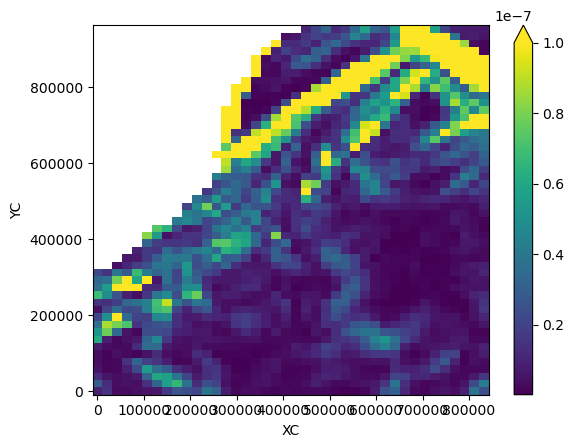

In [65]:
Ekterp.isel(time=0).plot(vmax=1e-7)

In [ ]:
PEk = xrft.isotropic_power_spectrum(Ekterp.sel(YC=slice(None,8e5),
                                               XC=slice(4e5,None)
                                              ).fillna(0.), dim=['YC','XC'],
                                    # detrend='constant',
                                    window='hann', window_correction=True,
                                    nfactor=2,
                                    truncate=True
                                   )
CEk = (xrft.isotropic_cross_spectrum(Psix_Ekterp.sel(YC=slice(None,8e5),
                                               XC=slice(4e5,None)
                                              ).fillna(0.).transpose('time','YC','XC'),
                                    By_terp.sel(YC=slice(None,8e5),
                                               XC=slice(4e5,None)
                                              ).fillna(0.), dim=['YC','XC'],
                                    detrend='constant',
                                    window='hann', window_correction=True,
                                     nfactor=2,
                                    truncate=True
                                   )
       - xrft.isotropic_cross_spectrum(Psiy_Ekterp.sel(YC=slice(None,8e5),
                                               XC=slice(4e5,None)
                                              ).fillna(0.).transpose('time','YC','XC'),
                                    Bx_terp.sel(YC=slice(None,8e5),
                                               XC=slice(4e5,None)
                                              ).fillna(0.), dim=['YC','XC'],
                                    detrend='constant',
                                    window='hann', window_correction=True,
                                       nfactor=2,
                                    truncate=True
                                   )
      )
Pbf = xrft.isotropic_power_spectrum(bfterp.sel(YC=slice(None,8e5),
                                               XC=slice(4e5,None)
                                              ).fillna(0.), dim=['YC','XC'],
                                    # detrend='constant',
                                    window='hann', window_correction=True,
                                    nfactor=2,
                                    truncate=True
                                   )
Cbf = (xrft.isotropic_cross_spectrum(Psix_bfterp.sel(YC=slice(None,8e5),
                                               XC=slice(4e5,None)
                                              ).fillna(0.).transpose('time','YC','XC'), 
                                     By_terp.sel(YC=slice(None,8e5),
                                               XC=slice(4e5,None)
                                              ).fillna(0.), dim=['YC','XC'],
                                    detrend='constant',
                                    window='hann', window_correction=True,
                                     nfactor=2,
                                    truncate=True
                                   )
       - xrft.isotropic_cross_spectrum(Psiy_bfterp.sel(YC=slice(None,8e5),
                                               XC=slice(4e5,None)
                                              ).fillna(0.).transpose('time','YC','XC'),
                                    Bx_terp.sel(YC=slice(None,8e5),
                                               XC=slice(4e5,None)
                                              ).fillna(0.), dim=['YC','XC'],
                                    detrend='constant',
                                    window='hann', window_correction=True,
                                       nfactor=2,
                                    truncate=True
                                   )
      )
Pwb = xrft.isotropic_power_spectrum(wbterp.sel(YC=slice(None,8e5),
                                               XC=slice(4e5,None)
                                              ).fillna(0.), dim=['YC','XC'],
                                    # detrend='constant',
                                    window='hann', window_correction=True,
                                    nfactor=2,
                                    truncate=True
                                   )
# Cwb = xrft.isotropic_cross_spectrum(np.abs(wsH_terp).sel(YC=slice(None,8e5),
#                                                XC=slice(4e5,None)
#                                               ).fillna(0.),
#                                     np.abs(bsH_terp).sel(YC=slice(None,8e5),
#                                                XC=slice(4e5,None)
#                                               ).fillna(0.),
#                                     dim=['YC','XC'],
#                                     detrend='constant',
#                                     window='hann', window_correction=True,
#                                     nfactor=2,
#                                     truncate=True
#                                    )

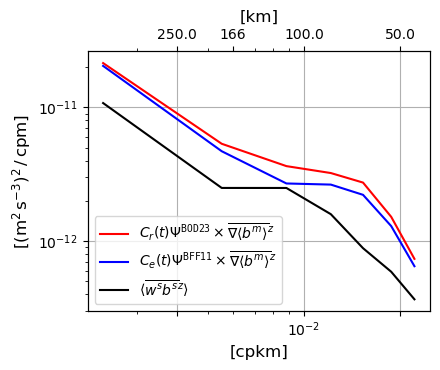

In [93]:
fig, ax = plt.subplots(figsize=(4.5,3.8))
ax2 = ax.twiny()
fig.set_tight_layout(True)

ax.plot(PEk.freq_r*1e3, PEk.mean('time'), 'r',
        label=r"$C_r(t)\Psi^{\tt BOD23}\times\overline{\nabla\langle b^m\rangle}^z$")
ax.plot(Pbf.freq_r*1e3, Pbf.mean('time'), 'b',
        label=r"$C_e(t)\Psi^{\tt BFF11}\times\overline{\nabla\langle b^m\rangle}^z$")
ax.plot(Pwb.freq_r*1e3, Pwb.mean('time'), 'k', 
        label=r"$\langle\overline{w^sb^s}^z\rangle$")
ax2.plot(PEk.freq_r*1e3, PEk.mean('time'), 'r', alpha=0,
        label=r"$C_r(t)\Psi^{\tt Bod}\times\overline{\nabla\langle b^m\rangle}^z$")

ax.set_xscale('log')
ax2.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='lower left', fontsize=10)

ax.grid(True)
ax.set_ylabel(r"[(m$^2\,$s$^{-3}$)$^2\,/\,$cpm]", fontsize=12)
ax.set_xlabel(r"[cpkm]", fontsize=12)

ax2.set_xlabel(r"[km]", fontsize=12)
ax.set_xticks([4e-3, 1e-2, 2e-2])
ax2.set_xticks([4e-3, 6e-3, 1e-2, 2e-2])
ax2.set_xticklabels([2.5e2, int(1e3/6), 1e2, 5e1])

plt.savefig(op.join(sdir,'Figs/eNATL60_region%02d_nC%02d_pwrspec.pdf' 
                    % (int(reg),nC)))

In [67]:
((CrEkC[::14]*CEk).real.mean('time')
        # * np.diff(CEk.freq_r)[0]
)

<xarray.DataArray (freq_r: 7)>
array([ 1.29588928e-04,  2.33200173e-04,  1.83777143e-04,  4.88021784e-05,
        5.14862916e-06, -3.07879927e-06, -2.95602654e-06])
Coordinates:
  * freq_r   (freq_r) float64 2.348e-06 5.525e-06 ... 1.877e-05 2.22e-05

In [ ]:
fig, ax = plt.subplots(figsize=(5,3.8))
ax2 = ax.twiny()
fig.set_tight_layout(True)

ax.plot(CEk.freq_r*1e3, 
        ((CrEkC[::14]*CEk).real.mean('time')
         * np.diff(CEk.freq_r)[0])[::-1].cumsum('freq_r')[::-1], 
        'r',
        label=r"$C_r(t)\widehat{\Psi^{\tt BOD23}}^*\times\widehat{\overline{\nabla\langle b^m\rangle}^z}$")
ax.plot(Cbf.freq_r*1e3, 
        ((CeC[::14]*Cbf).real.mean('time')
         * np.diff(Cbf.freq_r)[0])[::-1].cumsum('freq_r')[::-1], 
        'b',
        label=r"$C_e(t)\widehat{\Psi^{\tt BFF11}}^*\times\widehat{\overline{\nabla\langle b^m\rangle}^z}$")
ax.plot(
        # Cwb.freq_r*1e3, 
        # Cwb.real.mean('time'), 
        CwsbsH.freq_r*1e3,
        (CwsbsH.real.mean('time')
         * np.diff(CwsbsH.freq_r)[0])[::-1].cumsum('freq_r')[::-1],
        'k', 
        label=r"$\overline{\widehat{w^s}^*\widehat{b^s}}^z$")
ax2.plot(CEk.freq_r*1e3, 
         ((CrEkC[::14]*CEk).real.mean('time')
         * np.diff(CEk.freq_r)[0])[::-1].cumsum('freq_r')[::-1],
         'r', alpha=0,
        # label=r"$C_r(t)\Psi^{\tt Bod}\times\overline{\nabla\langle b^m\rangle}^z$"
        )
ax2.plot(
        # Cwb.freq_r*1e3, 
        # Cwb.real.mean('time'), 
        CwsbsH.freq_r*1e3,
        (CwsbsH.real.mean('time')
         * np.diff(CwsbsH.freq_r)[0])[::-1].cumsum('freq_r')[::-1],
        'k', alpha=0.,
        # label=r"$\overline{\widehat{w^s}^*\widehat{b^s}}^z$"
)

ax.fill_between(np.array([1/(2*np.sqrt(aC.mean()))*1e3, 4e-1]), 
                -.1e-9,1.75e-9, 
                color='k', alpha=.15)

ax.set_xscale('log')
ax2.set_xscale('log')
# ax.set_yscale('log')
ax.legend(loc='upper right', fontsize=11)

ax.grid(True)
ax.set_ylabel(r"[m$^2\,$s$^{-3}$]", fontsize=12)
ax.set_xlabel(r"[cpkm]", fontsize=12)

ax2.set_xlabel(r"[km]", fontsize=12)
ax.set_xticks([1e-2, 1e-1])
ax2.set_xticks([1e-2, 1e-1])
ax2.set_xticklabels([1e2, 1e1])
ax.set_ylim([-.1e-9,1.75e-9])
ax.set_xlim([4e-3,4e-1])
ax2.set_xlim([4e-3,4e-1])

plt.savefig(op.join(sdir,'Figs/eNATL60_region%02d_nC%02d_CUMSUMcrospec.pdf' 
                    % (int(reg),nC)))

In [ ]:
fig, ax = plt.subplots(figsize=(7,3))
fig.set_tight_layout(True)
# ax2 = ax.twinx()

ax.plot(range(89), WsBs.median(['YC','XC'],skipna=True).values, 
        'k', 
        label=r"$\langle\overline{w^sb^s}^z\rangle$"
       )
ax.plot(range(89), cbodEk.median(['YC','XC'],skipna=True).values, 
        'r', 
        label=r"$C_r(t)\Psi^{\tt BOD23}\times\overline{\nabla\langle b^m\rangle}^z$"
       )
ax.plot(range(89), cbff.median(['YC','XC'],skipna=True).values, 
        'b', 
        label=r"$C_e(t)\Psi^{\tt BFF11}\times\overline{\nabla\langle b^m\rangle}^z$"
       )
ax.plot(range(89), CbodEk.median(['YC','XC'],skipna=True).values, 
        'm--', 
 label=r"$\overline{C_r}^t\Psi^{\tt BOD23}\times\overline{\nabla\langle b^m\rangle}^z$"
       )
ax.plot(range(89), Cbff.median(['YC','XC'],skipna=True).values, 
        'c--', 
 label=r"$\overline{C_e}^t\Psi^{\tt BFF11}\times\overline{\nabla\langle b^m\rangle}^z$"
       )

ax.set_xticks(np.arange(89)[5::15])
ax.set_xticklabels(time[5::15], rotation=15)
# ax2.yaxis.label.set_color('red')         #setting up Y-axis label color to blue
# ax2.tick_params(axis='y', colors='red')  #setting up Y-axis tick color to black
# ax2.spines['right'].set_color('red')
ax.legend(loc='upper right', fontsize=10)
# ax2.legend(loc='upper right', fontsize=12)
ax.set_ylabel(r"[m$^2\,$s$^{-3}$]", fontsize=12)
# ax2.set_ylabel(r"$C_r(t)$", fontsize=13)
plt.savefig(op.join(sdir,'Figs/eNATL60_region%02d_nC%02d_TimeSeries.pdf' 
                    % (int(reg),nC)))

In [ ]:
fig, axes = plt.subplots(figsize=(9,10), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im1 = axes[0,0].pcolor(lonC, latC, WsBs.isel(time=0), 
                       cmap='bwr', rasterized=True,
                       vmin=-.7e-7, vmax=.7e-7
                      )
im2 = axes[0,1].pcolor(lonC, latC, cbodEk.isel(time=0), 
                       cmap='bwr', rasterized=True,
                       vmin=-.7e-7, vmax=.7e-7
                      )
# im2 = axes[1,0].pcolor(lonC, latC, CbodEbl.isel(time=0), 
#                  cmap='bwr', rasterized=True,
#                  vmin=-.6e-7, vmax=.6e-7
#                       )
im3 = axes[1,1].pcolor(lonC, latC, cbff.isel(time=0), 
                       cmap='bwr', rasterized=True,
                       vmin=-.7e-7, vmax=.7e-7
                      )

axes[0,0].pcolor(dss.lon.data, dss.lat.data, 
                 ds.maskC.where(ds.maskC==0.).isel(Z=0),
                 cmap='binary', vmin=-1, vmax=2, rasterized=True)
axes[0,1].pcolor(dss.lon.data, dss.lat.data, 
                 ds.maskC.where(ds.maskC==0.).isel(Z=0),
                 cmap='binary', vmin=-1, vmax=2, rasterized=True)
# axes[1,0].pcolor(dss.lon.data, dss.lat.data, 
#            ds.maskC.where(ds.maskC==0.).isel(Z=0),
#            cmap='binary', vmin=-1, vmax=2, rasterized=True)
axes[1,1].pcolor(dss.lon.data, dss.lat.data, 
                 ds.maskC.where(ds.maskC==0.).isel(Z=0),
                 cmap='binary', vmin=-1, vmax=2, rasterized=True)

axes[0,0].set_title(r"$\langle\overline{w^sb^s}^{z}\rangle$", fontsize=13)
axes[0,1].set_title(
r"$C_r(t) \Psi^{\tt BOD23} \times \overline{\nabla\langle b^m\rangle}^z$",
# r"$C_r(t)\frac{\Delta s|f|h_{Ek}H^2\overline{\nabla\langle b^m\rangle}^z \times {\bf z}}{(m_*u_*^3 + n_*w_*^3)^{2/3}} \times \overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=13)
# axes[1,0].set_title(
# r"$C_r\frac{\Delta s|f|h_{ePBL}H^2\overline{\nabla\langle b^m\rangle}^z \times {\bf z}}{(m_*u_*^3 + n_*w_*^3)^{2/3}} \times \overline{\nabla\langle b^m\rangle}^z$", 
#               fontsize=15)
axes[1,1].set_title(
r"$C_e(t) \Psi^{\tt BFF11} \times \overline{\nabla\langle b^m\rangle}^z$",
#r"$C_e(t)\frac{\Delta s}{L_{ML}}\frac{H^2\overline{\nabla\langle b^m\rangle}^z \times {\bf z}}{f} \times \overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=13)

axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')

axes[0,0].set_ylabel(r"Latitude", fontsize=12)
axes[1,1].set_ylabel(r"Latitude", fontsize=12)
axes[0,0].set_xlabel(r"Longitude", fontsize=12)
axes[1,1].set_xlabel(r"Longitude", fontsize=12)

# fig.subplots_adjust(right=0.86, hspace=0.22, wspace=.18)
# cbaxes1 = fig.add_axes([0.88, 0.35, 0.014, 0.3]) 
cbar1 = fig.colorbar(im1, orientation='horizontal', ax=axes, shrink=.6)
cbar1.set_label(r"[m$^2\,$s$^{-3}$]", fontsize=12)

plt.savefig(op.join(sdir,'Figs/eNATL60_MLI_region%02d_nC%02d.pdf' % (reg,nC)))

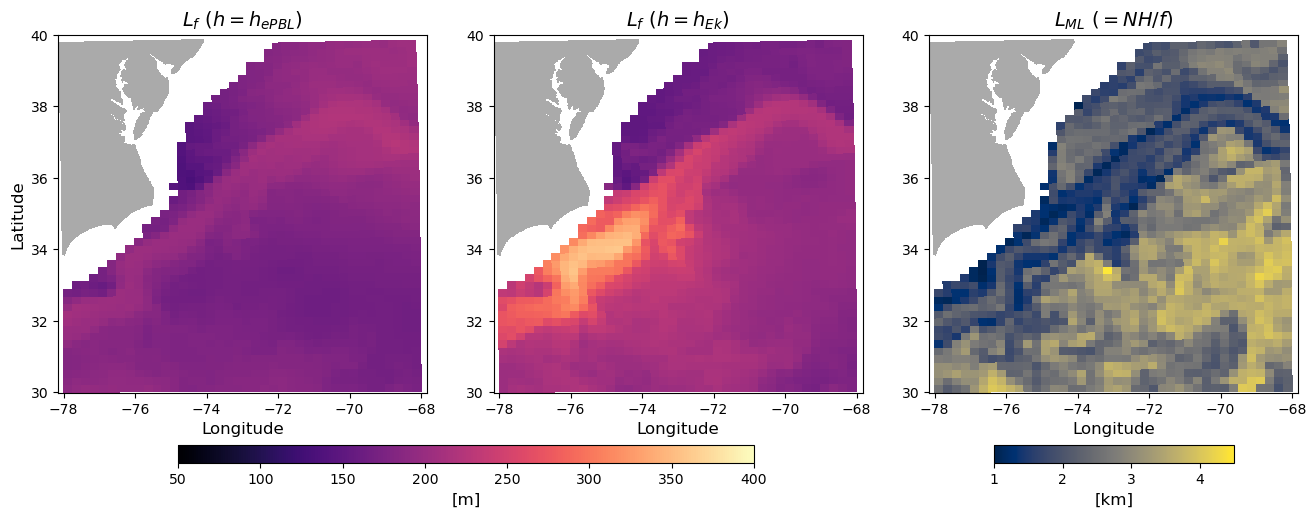

In [46]:
fig, axes = plt.subplots(figsize=(16,6), nrows=1, ncols=3)

im1 = axes[0].pcolor(lonC, latC, Lf_Eblb.where(Db>2e2).isel(time=0), 
                 cmap='magma', rasterized=True,
                 vmin=50, vmax=4e2
                 )
axes[1].pcolor(lonC, latC, Lf_Ekb.where(Db>2e2).isel(time=0), 
                 cmap='magma', rasterized=True,
                 vmin=50, vmax=4e2
                 )
im2 = axes[2].pcolor(lonC, latC, Lf_oldb.where(Db>2e2).isel(time=0)*1e-3, 
                 cmap='cividis', rasterized=True,
                 vmin=1., vmax=4.5e0
                 )

axes[0].pcolor(dss.lon.data, dss.lat.data, 
           ds.maskC.where(ds.maskC==0.).isel(Z=0),
           cmap='binary', vmin=-1, vmax=2, rasterized=True)
axes[1].pcolor(dss.lon.data, dss.lat.data, 
           ds.maskC.where(ds.maskC==0.).isel(Z=0),
           cmap='binary', vmin=-1, vmax=2, rasterized=True)
axes[2].pcolor(dss.lon.data, dss.lat.data, 
           ds.maskC.where(ds.maskC==0.).isel(Z=0),
           cmap='binary', vmin=-1, vmax=2, rasterized=True)

axes[0].set_title(r"$L_{f}\ (h=h_{ePBL})$", fontsize=14)
axes[1].set_title(r"$L_{f}\ (h=h_{Ek})$", fontsize=14)
axes[2].set_title(r"$L_{ML}\ (= NH/f)$", fontsize=14)

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')

axes[0].set_ylabel(r"Latitude", fontsize=12)
axes[0].set_xlabel(r"Longitude", fontsize=12)
axes[1].set_xlabel(r"Longitude", fontsize=12)
axes[2].set_xlabel(r"Longitude", fontsize=12)

fig.subplots_adjust(bottom=0.15, wspace=.18)
cbaxes1 = fig.add_axes([0.2, 0.1, 0.36, 0.03]) 
cbar1 = fig.colorbar(im1, orientation='horizontal', cax=cbaxes1)
cbar1.set_label(r"[m]", fontsize=12)
cbaxes2 = fig.add_axes([0.71, 0.1, 0.15, 0.03]) 
cbar2 = fig.colorbar(im2, orientation='horizontal', cax=cbaxes2)
cbar2.set_label(r"[km]", fontsize=12)

plt.savefig(op.join(sdir,'Figs/eNATL60_Ls_region%02d_nC%02d.pdf' % (reg,nC)))

In [49]:
xhist_bodEk = xhist(cbodEk.chunk({'time':1}), 
      WsBs.chunk({'time':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()
# xhist_bodEbl = xhist(cbodEbl.chunk({'time':1}), 
#       WsBs.chunk({'time':1}),
#       bins=[np.logspace(-10,-6,30), 
#             np.concatenate((-np.logspace(-6,-10,30),
#                             np.concatenate((np.linspace(-9e-11,9e-11,5),
#                                             np.logspace(-10,-6,30)))))
#            ]
#      ).compute()
xhist_bff = xhist(cbff.chunk({'time':1}), 
      WsBs.chunk({'time':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()

Task exception was never retrieved
future: <Task finished name='Task-541732' coro=<Client._gather.<locals>.wait() done, defined at /tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/distributed/client.py:2119> exception=AllExit()>
Traceback (most recent call last):
  File "/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/distributed/client.py", line 2128, in wait
    raise AllExit()
distributed.client.AllExit


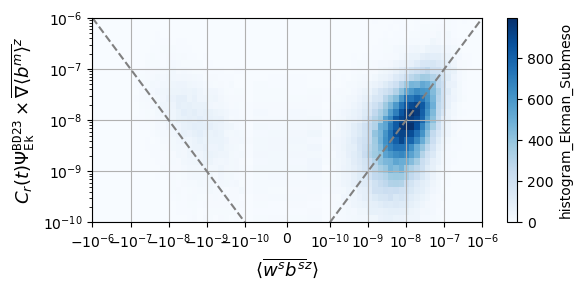

In [50]:
fig, ax = plt.subplots(figsize=(6,2.8))
fig.set_tight_layout(True)

xhist_bodEk.plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\langle\overline{w^sb^s}^z\rangle$", fontsize=12)
ax.set_ylabel(
    r"$C_r(t)\Psi^{\tt Bod23}_{\tt Ek}\times\overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=12)

ax.grid(True)
ax.set_yticks([1e-11,1e-10,1e-9,1e-8,1e-7,1e-6])
ax.set_xticks([-1e-6,-1e-7,-1e-8,-1e-9,-1e-10,-1e-11,
               0,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6])
ax.set_xticklabels([r"$-10^{-6}$",r"$-10^{-7}$",r"$-10^{-8}$",
                    r"$-10^{-9}$",r"$-10^{-10}$",r"$-10^{-11}$",
                    0,r"$10^{-11}$",r"$10^{-10}$",r"$10^{-9}$",
                    r"$10^{-8}$",r"$10^{-7}$",r"$10^{-6}$"], 
                   rotation=15)

plt.savefig(op.join(sdir,'Figs/eNATL60-wb_medianCrEk-hist_region%02d_nC%02d.pdf' 
                    % (reg,nC)))

In [ ]:
fig, ax = plt.subplots(figsize=(6,3))
fig.set_tight_layout(True)

xhist_bodEbl.plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\langle\overline{w^sb^s}^z\rangle$", fontsize=13)
ax.set_ylabel(r"$\Psi^{\tt Bod}_{\tt ePBL}\times\overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=13)

ax.grid(True)

plt.savefig(op.join(sdir,'Figs/eNATL60-wb_medianCrePBL-hist_region%02d_nC%02d.pdf' 
                    % (reg,nC)))

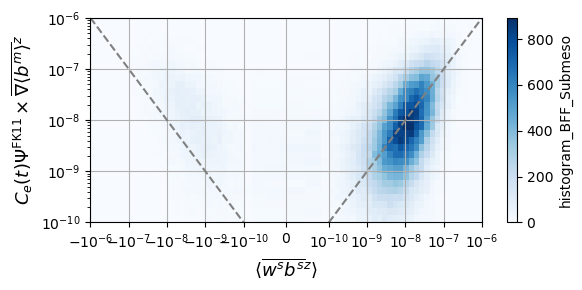

In [51]:
fig, ax = plt.subplots(figsize=(6,2.8))
fig.set_tight_layout(True)

xhist_bff.plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\langle\overline{w^sb^s}^z\rangle$", fontsize=12)
ax.set_ylabel(
    r"$C_e(t)\Psi^{\tt BFF11}\times\overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=12)

ax.grid(True)
ax.set_yticks([1e-11,1e-10,1e-9,1e-8,1e-7,1e-6])
ax.set_xticks([-1e-6,-1e-7,-1e-8,-1e-9,-1e-10,-1e-11,
               0,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6])
ax.set_xticklabels([r"$-10^{-6}$",r"$-10^{-7}$",r"$-10^{-8}$",
                    r"$-10^{-9}$",r"$-10^{-10}$",r"$-10^{-11}$",
                    0,r"$10^{-11}$",r"$10^{-10}$",r"$10^{-9}$",
                    r"$10^{-8}$",r"$10^{-7}$",r"$10^{-6}$"], 
                   rotation=15)

plt.savefig(op.join(sdir,'Figs/eNATL60-wb_medianCe-hist_region%02d_nC%02d.pdf' 
                    % (reg,nC)))

In [ ]:
fig, ax = plt.subplots(figsize=(6,3))
fig.set_tight_layout(True)

(xhist_bodEbl - xhist_bff.data).plot(ax=ax, cmap='RdBu_r', vmax=3e2, vmin=-3e2)

ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\langle\overline{w^sb^s}^z\rangle$", fontsize=13)
ax.set_ylabel(r"$C(t)\Psi\times\overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=13)
ax.set_title(r"Bodner$-$BFF", fontsize=14)

plt.savefig(op.join(sdir,'Figs/eNATL60-BodePBL-BFF-hist_region%02d_nC%02d.pdf' 
                    % (reg,nC)))

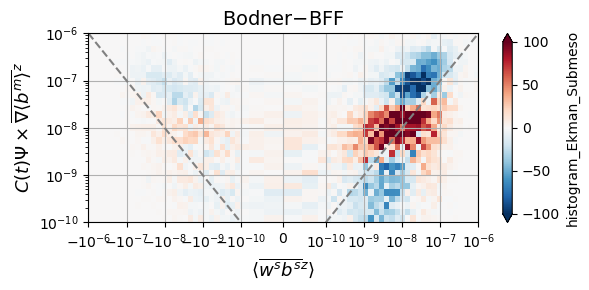

In [55]:
fig, ax = plt.subplots(figsize=(6,3))
fig.set_tight_layout(True)

(xhist_bodEk - xhist_bff.data).plot(ax=ax, cmap='RdBu_r', vmax=1e2, vmin=-1e2)

ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\langle\overline{w^sb^s}^z\rangle$", fontsize=13)
ax.set_ylabel(r"$C(t)\Psi\times\overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=13)
ax.set_title(r"Bodner$-$BFF", fontsize=14)

ax.grid(True)
plt.savefig(op.join(sdir,'Figs/eNATL60-BodEk-BFF-hist_region%02d_nC%02d.pdf' 
                    % (reg,nC)))

In [53]:
xhist_MLI = xhist(cbff.chunk({'time':1}), 
                  cbodEk.chunk({'time':1}), 
      bins=[np.logspace(-11,-6,30), 
            np.logspace(-11,-6,30)
           ]
     ).compute()

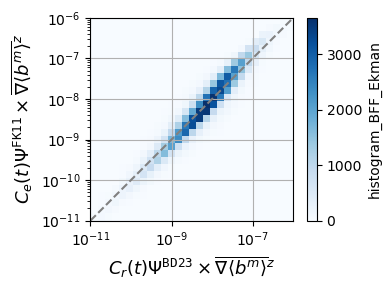

In [54]:
fig, ax = plt.subplots(figsize=(4,3))
fig.set_tight_layout(True)

xhist_MLI.plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-11,1e-6), np.linspace(1e-11,1e-6), c='grey', ls='--')
# ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-11,1e-6])
ax.set_xlim([1e-11,1e-6])
ax.set_xlabel(r"$C_r(t)\Psi^{\tt BD23}\times\overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=13)
ax.set_ylabel(r"$C_e(t)\Psi^{\tt FK11}\times\overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=13)

ax.grid(True)
ax.set_aspect('equal')

plt.savefig(op.join(sdir,'Figs/eNATL60-wb_MLI-hist_region%02d_nC%02d.pdf' 
                    % (int(reg),nC)))

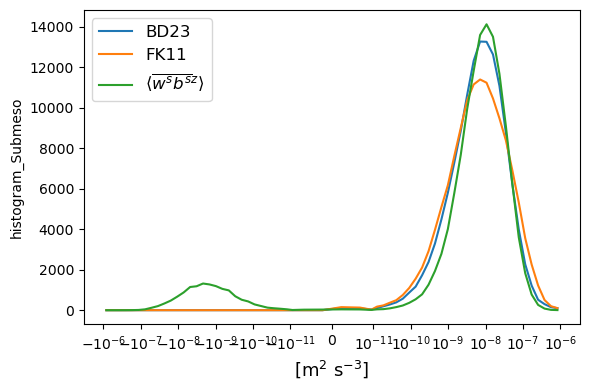

In [56]:
fig, ax = plt.subplots(figsize=(6,4))
fig.set_tight_layout(True)

xhist(CbodEk.chunk({'time':1}), 
      bins=[np.concatenate((-np.logspace(-6,-11,30),
                            np.concatenate((np.linspace(-9e-12,9e-12,5),
                                            np.logspace(-11,-6,30)))))
           ]
     ).plot(ax=ax, label=r"BD23")
# xhist(CbodEbl.chunk({'time':1}), 
#       bins=[np.concatenate((-np.logspace(-6,-11,30),
#                             np.concatenate((np.linspace(-9e-12,9e-12,5),
#                                             np.logspace(-11,-6,30)))))
#            ]
#      ).plot(ax=ax, label=r"Bodner (ePBL)", ls='--')
xhist(Cbff.chunk({'time':1}), 
      bins=[np.concatenate((-np.logspace(-6,-11,30),
                            np.concatenate((np.linspace(-9e-12,9e-12,5),
                                            np.logspace(-11,-6,30)))))
           ]
     ).plot(ax=ax, label=r"FK11")
xhist(WsBs.chunk({'time':1}), 
      bins=[np.concatenate((-np.logspace(-6,-11,30),
                            np.concatenate((np.linspace(-9e-12,9e-12,5),
                                            np.logspace(-11,-6,30)))))
           ]
     ).plot(ax=ax, label=r"$\langle\overline{w^sb^s}^z\rangle$")
ax.set_xscale('symlog', linthresh=1e-11)
ax.set_xlabel(r"[m$^2$ s$^{-3}$]", fontsize=13)
ax.legend(loc='upper left', fontsize=12)
plt.savefig(op.join(sdir,'Figs/eNATL60-wb-1Dhist_region%02d_nC%02d.pdf' 
                    % (reg,nC)))

In [55]:
Cl = .25
nCbodEk = (bodEk/Cl).where(Db>2e2)
nCbodEbl = (bodEbl/Cl).where(Db>2e2)
nCbff = (bff).where(Db>2e2)
nCbodEk.name = 'Ekman'
nCbodEbl.name = 'ePBL'
nCbff.name = 'BFF'

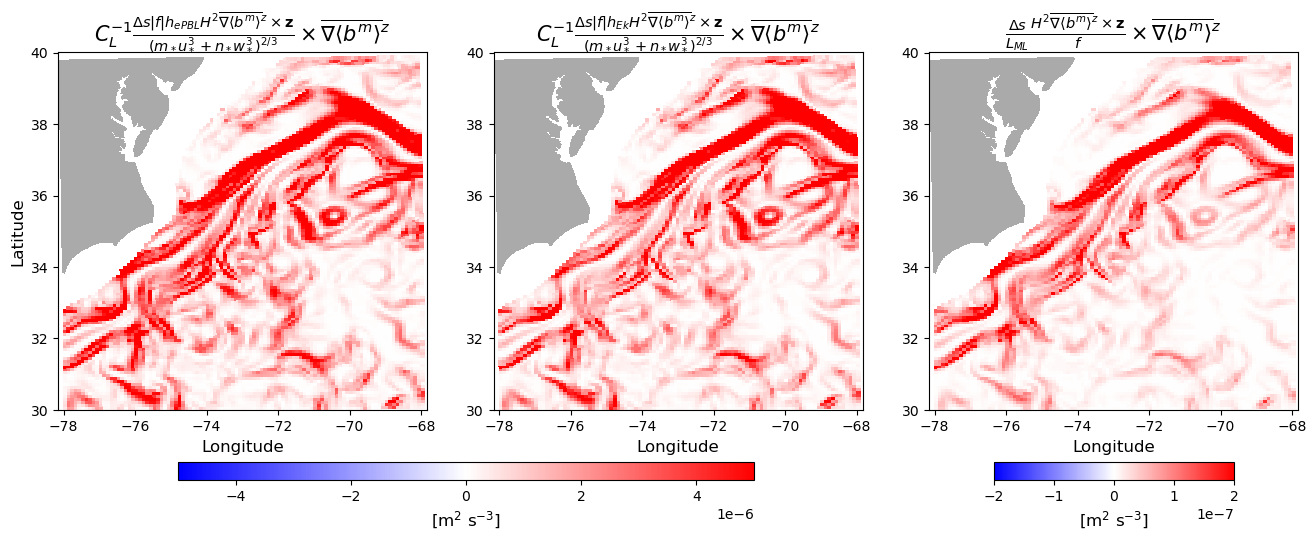

In [62]:
fig, axes = plt.subplots(figsize=(16,6), nrows=1, ncols=3)
# fig.set_tight_layout(True)

im1 = axes[0].pcolor(lonC, latC, nCbodEbl.isel(time=0), 
                 cmap='bwr', rasterized=True,
                 vmin=-5e-6, vmax=5e-6
                      )
axes[1].pcolor(lonC, latC, nCbodEk.isel(time=0), 
                 cmap='bwr', rasterized=True,
                 vmin=-5e-6, vmax=5e-6
                      )
im3 = axes[2].pcolor(lonC, latC, nCbff.isel(time=0), 
                 cmap='bwr', rasterized=True,
                 vmin=-2e-7, vmax=2e-7
                      )

axes[0].pcolor(dss.lon.data, dss.lat.data, 
           ds.maskC.where(ds.maskC==0.).isel(Z=0),
           cmap='binary', vmin=-1, vmax=2, rasterized=True)
axes[1].pcolor(dss.lon.data, dss.lat.data, 
           ds.maskC.where(ds.maskC==0.).isel(Z=0),
           cmap='binary', vmin=-1, vmax=2, rasterized=True)
axes[2].pcolor(dss.lon.data, dss.lat.data, 
           ds.maskC.where(ds.maskC==0.).isel(Z=0),
           cmap='binary', vmin=-1, vmax=2, rasterized=True)

axes[0].set_title(
r"$C_L^{-1}\frac{\Delta s|f|h_{ePBL}H^2\overline{\nabla\langle b^m\rangle}^z \times {\bf z}}{(m_*u_*^3 + n_*w_*^3)^{2/3}} \times \overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=15)
axes[1].set_title(
r"$C_L^{-1}\frac{\Delta s|f|h_{Ek}H^2\overline{\nabla\langle b^m\rangle}^z \times {\bf z}}{(m_*u_*^3 + n_*w_*^3)^{2/3}} \times \overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=15)
axes[2].set_title(
r"$\frac{\Delta s}{L_{ML}}\frac{H^2\overline{\nabla\langle b^m\rangle}^z \times {\bf z}}{f} \times \overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=15)

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')

axes[0].set_ylabel(r"Latitude", fontsize=12)
axes[0].set_xlabel(r"Longitude", fontsize=12)
axes[1].set_xlabel(r"Longitude", fontsize=12)
axes[2].set_xlabel(r"Longitude", fontsize=12)

fig.subplots_adjust(bottom=0.15, wspace=.18)
cbaxes1 = fig.add_axes([0.2, 0.1, 0.36, 0.03]) 
cbar1 = fig.colorbar(im1, orientation='horizontal', cax=cbaxes1)
cbar1.set_label(r"[m$^2$ s$^{-3}$]", fontsize=12)
cbaxes2 = fig.add_axes([0.71, 0.1, 0.15, 0.03]) 
cbar2 = fig.colorbar(im3, orientation='horizontal', cax=cbaxes2)
cbar2.set_label(r"[m$^2$ s$^{-3}$]", fontsize=12)

plt.savefig(op.join(sdir,'Figs/eNATL60_MLI-noCs_region%02d_nC%02d.pdf' 
                    % (reg,nC)))

In [60]:
xhist_bodEkbff = xhist(nCbff.chunk({'time':1}), nCbodEk.chunk({'time':1}), 
      bins=[np.concatenate((np.linspace(0,9e-11,5),
                            np.logspace(-10,-6,30))), 
            np.concatenate((np.linspace(0,9e-10,5),
                            np.logspace(-9,-5,30)))
           ]
     ).compute()
xhist_bodEblEk = xhist(nCbodEk.chunk({'time':1}), nCbodEbl.chunk({'time':1}), 
      bins=[np.concatenate((np.linspace(0,9e-10,5),
                            np.logspace(-9,-5,30))), 
            np.concatenate((np.linspace(0,9e-10,5),
                            np.logspace(-9,-5,30)))
           ]
     ).compute()

In [68]:
xhist_bodEblbff = xhist(nCbff.chunk({'time':1}), nCbodEbl.chunk({'time':1}), 
      bins=[np.concatenate((np.linspace(0,9e-11,5),
                            np.logspace(-10,-6,30))), 
            np.concatenate((np.linspace(0,9e-10,5),
                            np.logspace(-9,-5,30)))
           ]
     ).compute()

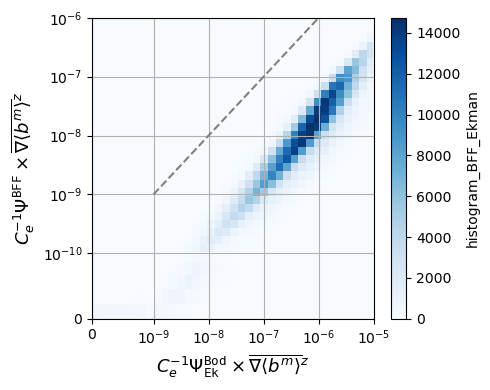

In [70]:
fig, ax = plt.subplots(figsize=(5,4))
fig.set_tight_layout(True)

im = xhist_bodEkbff.plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-9,1e-5), np.linspace(1e-9,1e-5), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-9)
ax.set_yscale('symlog', linthresh=1e-10)
ax.set_ylim([0,1e-6])
ax.set_xlim([0,1e-5])

# ax.set_aspect('equal')

ax.set_xlabel(r"$C_e^{-1}\Psi^{\tt Bod}_{\tt Ek}\times\overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=13)
ax.set_ylabel(r"$C_e^{-1}\Psi^{\tt BFF}\times\overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=13)
# fig.colorbar(im, ax=ax, shrink=.7)
ax.grid(True)
plt.savefig(op.join(sdir,'Figs/eNATL60-MLI_noCsEk-hist_region%02d.pdf' % reg))

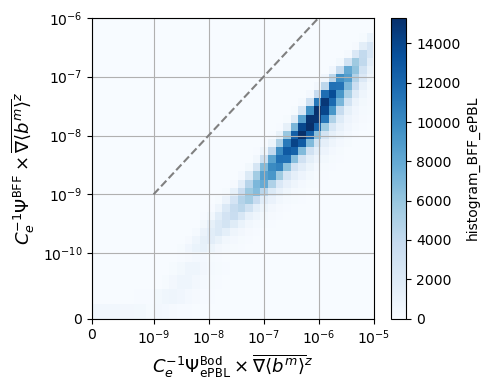

In [71]:
fig, ax = plt.subplots(figsize=(5,4))
fig.set_tight_layout(True)

im = xhist_bodEblbff.plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-9,1e-5), np.linspace(1e-9,1e-5), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-9)
ax.set_yscale('symlog', linthresh=1e-10)
ax.set_ylim([0,1e-6])
ax.set_xlim([0,1e-5])

# ax.set_aspect('equal')

ax.set_xlabel(r"$C_e^{-1}\Psi^{\tt Bod}_{\tt ePBL}\times\overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=13)
ax.set_ylabel(r"$C_e^{-1}\Psi^{\tt BFF}\times\overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=13)
# fig.colorbar(im, ax=ax, shrink=.7)
ax.grid(True)
plt.savefig(op.join(sdir,'Figs/eNATL60-MLI_noCsEbl-hist_region%02d.pdf' % reg))

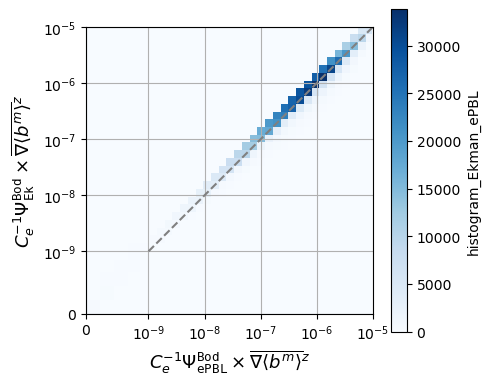

In [65]:
fig, ax = plt.subplots(figsize=(5,4))
fig.set_tight_layout(True)

im = xhist_bodEblEk.plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-9,1e-5), np.linspace(1e-9,1e-5), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-9)
ax.set_yscale('symlog', linthresh=1e-9)
ax.set_ylim([0,1e-5])
ax.set_xlim([0,1e-5])

ax.set_aspect('equal')

ax.set_xlabel(r"$C_e^{-1}\Psi^{\tt Bod}_{\tt ePBL}\times\overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=13)
ax.set_ylabel(r"$C_e^{-1}\Psi^{\tt Bod}_{\tt Ek}\times\overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=13)
# fig.colorbar(im, ax=ax, shrink=.7)
ax.grid(True)
plt.savefig(op.join(sdir,'Figs/eNATL60-ePBL-Ek_noCs-hist_region%02d.pdf' % reg))